The DBLEU Loss follow this paper : https://openreview.net/forum?id=S1x2aiRqFX 

#Import library

In [104]:
!nvidia-smi

Fri May 20 13:49:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    37W / 250W |   3651MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
import sys
sys.path.append('/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Library/')
!pip install --upgrade pythainlp
!pip install torchinfo
!pip install torchviz

In [107]:
from data_processing_non import dictionary
from model_dataloader import EncoderDecoder

In [108]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms, models
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary

from sklearn.model_selection import train_test_split

In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Data set and Data loader


In [110]:
def get_identical_matrix(vector):
  identical_matrix = torch.eye(len(vector))

  for i in range(len(vector)):
    for j in range(len(vector)):
      identical_matrix[i, j] = vector[i] == vector[j]

  return identical_matrix

def get_n_gram_hadamard_operation(matrix, n = 4):
  outputs = []
  matrix_n = matrix
  outputs.append(matrix)

  w = matrix.shape[0]
  h = matrix.shape[1]

  for i in range(1, n):
    if w-i <= 0 or h-i <= 0:
      break
    matrix_n = matrix[:-i, :-i] * matrix_n[1:, 1:]
    outputs.append(matrix_n)

  return outputs 

def get_similarity_matrix(pred, caption):
  T = len(caption)
  output = torch.zeros(T, T)
  for i in range(T):
    for j in range(T):
      output[i, j] = pred[i, caption[j]].contiguous()
  return output

In [111]:
class FlickrDataset_Bleu_loss(Dataset):
    def __init__(self, 
                 captions_files, 
                 image_dir = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Data/archive/Images/", 
                 transform=None,
                 dictionary=dictionary,
                 test = False):
      
      self.image_dir = image_dir

      if type(captions_files) is str:
        self.dfs = pd.read_csv(captions_files)
        self.dfs = [self.df]
      elif type(captions_files) is list:
        for i in range(len(captions_files)):
          if  type(captions_files[i]) is str:
            captions_files[i] = pd.read_csv(captions_files[i])
        self.dfs = captions_files

      self.transform = transform
      self.test = test
      self.img_id = []
      self.img = {}
      self.caption = {}
      self.dictionary = dictionary

      self.caption_n_gram_count = {}

      unique_image = self.dfs[0]['image'].unique()

      for i in tqdm(range(len(unique_image))):
        img_id = unique_image[i]
        if img_id in self.caption:
          continue
        self.img_id.append(img_id)
        self.caption[img_id] = []
        self.caption_n_gram_count[img_id] = []
      
      for df in self.dfs:

        for i in tqdm(range(len(df))):
          img_id = df.iloc[i]['image']
          caption = df.iloc[i]['tokenized_caption_th']

          caption = caption[1:-1]
          caption = caption.split(",")
          caption = [word[1:].replace("'", "") for word in caption] 
          caption = self.dictionary.numericalize(caption)
          caption = torch.tensor(caption)
          
          identical_matrix = get_identical_matrix(caption[1:-1])
          n_gram_indentical_matrices = get_n_gram_hadamard_operation(identical_matrix)
          n_gram_count = [torch.sum(matrix, dim = 1) for matrix in n_gram_indentical_matrices]
          self.caption[img_id].append(caption)
          self.caption_n_gram_count[img_id].append(n_gram_count)
        
        
    def __len__(self):
      return len(self.img_id)
    
    def __getitem__(self, idx): 

      img_id = self.img_id[idx]
      if img_id not in self.img:
        img_path = os.path.join(self.image_dir, img_id)
        img = Image.open(img_path).convert("RGB")
        self.img[img_id] = img

      img = self.img[img_id]
      randomized_index = random.randint(0, len(self.caption[img_id])-1)
      caption = self.caption[img_id][randomized_index]
      caption_n_gram_count = self.caption_n_gram_count[img_id][randomized_index]

      if self.transform is not None:
        transformed_img = self.transform(img)

      if not self.test:
        return transformed_img, caption, caption_n_gram_count, img

      return transformed_img, caption, caption_n_gram_count, img, self.caption[img_id]
      

In [112]:
# Collate_fn for calling to transform a batch before return. 
class Collate_fn:
  def __init__(self, pad_value, batch_first=False):
    self.pad_value = pad_value       
    self.batch_first = batch_first    
        
  def __call__(self, batch):
    transformed_imgs = [item[0].unsqueeze(0) for item in batch]
    transformed_imgs = torch.cat(transformed_imgs, dim=0)    
        
    captions = [item[1] for item in batch]   
    captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
    
    if len(batch[0]) > 4:
      return transformed_imgs, captions, [item[2] for item in batch], [item[3] for item in batch], [item[4] for item in batch]

    return transformed_imgs, captions, [item[2] for item in batch], [item[3] for item in batch]

In [113]:
dataframe_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Data/archive/"

In [114]:
train_captions_files = [dataframe_path+"captions_train.csv"]
val_captions_files = [dataframe_path+"captions_val.csv"]
test_captions_files = [dataframe_path+"captions_test.csv"]

image_size = 299

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

In [115]:
batch_size = 32
train_flickr_bleu_dataset = FlickrDataset_Bleu_loss(transform = train_transform, captions_files = train_captions_files)
train_flickr_bleu_dataloader = torch.utils.data.DataLoader( train_flickr_bleu_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 
val_flickr_bleu_dataset = FlickrDataset_Bleu_loss(transform = val_transform, captions_files = val_captions_files)
val_flickr_bleu_dataloader = torch.utils.data.DataLoader( val_flickr_bleu_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 
test_flickr_bleu_dataset = FlickrDataset_Bleu_loss(transform = val_transform, captions_files = test_captions_files, test = True)
test_flickr_bleu_dataloader = torch.utils.data.DataLoader( test_flickr_bleu_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 

  0%|          | 0/5663 [00:00<?, ?it/s]

  0%|          | 0/28315 [00:00<?, ?it/s]

  0%|          | 0/1214 [00:00<?, ?it/s]

  0%|          | 0/6070 [00:00<?, ?it/s]

  0%|          | 0/1214 [00:00<?, ?it/s]

  0%|          | 0/6070 [00:00<?, ?it/s]

In [116]:
len(next(iter(test_flickr_bleu_dataloader)))

5

#BLEU Loss Function

In [117]:
from torch.autograd import Variable
eps = 1e-8
class BLEU_loss(nn.Module):
  def __init__(self, N_max = 4):
    super().__init__()
    self.N_max = N_max 
    self.weight = torch.tensor([0.1, 0.3, 0.3, 0.3])
        
  def forward(self, preds, captions, Cs):
    prec = torch.zeros(len(preds))
    BP = torch.zeros(len(preds))

    for index in range(len(preds)):
      caption = captions[index]

      stop_word_index = (caption == 2).nonzero()[0]
      caption = caption[1:stop_word_index]
      T = len(caption)

      pred = preds[index]
      text_output = torch.argmax(pred, dim = 1)
      if 2 in text_output:
        stop_word_index_pred = (text_output == 2).nonzero()[0]
        text_output = text_output[:stop_word_index_pred]
      else :
        text_output = text_output
      pred = pred[:stop_word_index]
      pred = nn.functional.softmax(pred, dim=1)

      similarity_matrix = get_similarity_matrix(pred, caption)
      Ms = get_n_gram_hadamard_operation(similarity_matrix) 

      C = Cs[index]
      Os = torch.tensor([0.0 for _ in range(self.N_max)])

      for n in range(self.N_max):
        if n >= len(Ms):
          break
        M = Ms[n]
        diag = torch.diagonal(M, 0)
        temp = 1 + torch.sum(M, dim = 1) - diag 

        appearance_number = C[n]
        min_part = appearance_number/temp
        min_part = torch.clamp(min_part, max = 1)

        #print(M.shape, appearance_number.shape, min_part.shape)
        temp = (M.T/appearance_number*min_part).T
        temp = torch.sum(temp)
        Os[n] = torch.log(temp/(T-n)+eps)

      number_word_real = len(caption)
      number_word_pred = len(text_output)
      if number_word_real > number_word_pred:
        BP[index] = -torch.log(torch.exp(torch.tensor(1-number_word_real/(number_word_pred+eps))))
      prec[index] = -torch.sum(Os*self.weight)
      

    BP = torch.mean(BP) 
    prec = torch.mean(prec) 

    return BP+prec

#Model

In [118]:
#Config

embed_size=300
vocab_size = len(dictionary.stoi)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 1e-3
number_of_decode_layer = 1

model_name = "bleu_loss_model_9_1"
base_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/"
crossentropy_path = base_path + "baseline_"+model_name+"_state.pth"
mixed_path = base_path + model_name+"_state.pth"

In [119]:
transformed_img, captions, caption_n_gram_count, img = next(iter(train_flickr_bleu_dataloader))
transformed_img, captions = transformed_img.to(device), captions.to(device)

In [120]:
model = EncoderDecoder(embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim, number_of_decode_layer).to(device)

In [121]:
#best_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/baseline_attention_cross_ling_model_state.pth"
#best = torch.load(best_path)
#model.load_state_dict(best['state_dict'])

#Training


In [122]:
bleu_loss_fn = BLEU_loss()
criterion = nn.CrossEntropyLoss(ignore_index=dictionary.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 0, min_lr = 1e-7)

In [123]:
def save_model(model,num_iteration, crossentropy):
    best_path = crossentropy_path if crossentropy == True else mixed_path
    model_state = {
        'num_epochs':num_iteration,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }
    torch.save(model_state, best_path)
    print(best_path)

In [124]:
import math
num_epoch = 25
best_val = float('inf')
lrs = []

train_losses = []
val_losses = []

train_bleu_losses = []
train_cross_entropy_losses = []

val_bleu_losses = []
val_cross_entropy_losses = []



for i in tqdm(range(num_epoch)): 

  model.train()
  
  total_train_loss = 0 
  total_train_bleu_loss = 0
  total_train_cross_entropy_loss = 0
  count = 0 

  for transformed_img, captions, caption_n_gram_count, _ in tqdm(train_flickr_bleu_dataloader):
  
    optimizer.zero_grad()
    transformed_img, captions = transformed_img.to(device), captions.to(device)

    outputs, attentions = model(transformed_img, captions)
    bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
    criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

    train_loss = criterion_loss
    train_loss.backward()

    total_train_bleu_loss += bleu_loss
    total_train_cross_entropy_loss += criterion_loss
    total_train_loss += train_loss
    count+= 1
    optimizer.step()

  total_train_loss /= count
  total_train_bleu_loss /= count
  total_train_cross_entropy_loss /= count
  scheduler.step(total_train_loss)
  lrs.append(optimizer.param_groups[0]['lr'])

  train_losses.append(train_loss.item())
  train_bleu_losses.append(total_train_bleu_loss.item())
  train_cross_entropy_losses.append(total_train_cross_entropy_loss.item())

  model.eval()
  total_val_loss = 0 
  total_val_bleu_loss = 0
  total_val_cross_entropy_loss = 0
  count = 0 
  with torch.no_grad():
    for transformed_img, captions, caption_n_gram_count, _ in val_flickr_bleu_dataloader:
      transformed_img, captions = transformed_img.to(device), captions.to(device)
      outputs, attentions = model(transformed_img, captions)
      bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
      criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

      val_loss = criterion_loss

      total_val_loss += val_loss
      total_val_bleu_loss += bleu_loss
      total_val_cross_entropy_loss += criterion_loss
      count += 1

    total_val_loss /= count
    total_val_bleu_loss /= count
    total_val_cross_entropy_loss/= count

    val_losses.append(total_val_loss.item())
    val_bleu_losses.append(total_val_bleu_loss.item())
    val_cross_entropy_losses.append(total_val_cross_entropy_loss.item())
    
    if bleu_loss < best_val:
      best_val = bleu_loss
      save_model(model, i, True)

    transformed_img, captions, _, img = next(iter(val_flickr_bleu_dataloader)) 
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)

    print("LR : ", lrs[-1],"Train loss : ", total_train_loss, "Val loss : ",total_val_loss, "BLEU loss : ",bleu_loss)
    for i in range(5):
      print("Real: ", "".join([ dictionary.itos[i] for i in captions[i].cpu().detach().numpy() ]))
      print("Prodicted: ", "".join(text_output[i]))
      plt.imshow(img[i])
      plt.show()
    print()

  

Output hidden; open in https://colab.research.google.com to view.

In [125]:
import math

num_epoch = 5
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 0, min_lr = 1e-7)

best = torch.load(crossentropy_path)
model.load_state_dict(best['state_dict'])

for i in tqdm(range(num_epoch)): 

  model.train()
  total_train_loss = 0 
  total_train_bleu_loss = 0
  total_train_cross_entropy_loss = 0
  count = 0 

  for transformed_img, captions, caption_n_gram_count, _ in tqdm(train_flickr_bleu_dataloader):
  
    optimizer.zero_grad()
    transformed_img, captions = transformed_img.to(device), captions.to(device)

    outputs, attentions = model(transformed_img, captions)
    bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
    criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

    train_loss = bleu_loss * 0.10 + criterion_loss * 0.90
    train_loss.backward()

    total_train_loss += train_loss
    total_train_bleu_loss += bleu_loss
    total_train_cross_entropy_loss += criterion_loss
    count += 1
    optimizer.step()

  total_train_loss /= count
  total_train_bleu_loss /= count
  total_train_cross_entropy_loss /= count
  
  train_losses.append(train_loss.item())
  train_bleu_losses.append(total_train_bleu_loss.item())
  train_cross_entropy_losses.append(total_train_cross_entropy_loss.item())
  
  scheduler.step(total_train_loss)
  lrs.append(optimizer.param_groups[0]['lr'])
  train_losses.append(train_loss.item())

  model.eval()
  total_val_loss = 0 
  total_val_bleu_loss = 0
  total_val_cross_entropy_loss = 0
  count = 0 
  with torch.no_grad():
    for transformed_img, captions, caption_n_gram_count, _ in val_flickr_bleu_dataloader:
      transformed_img, captions = transformed_img.to(device), captions.to(device)
      outputs, attentions = model(transformed_img, captions)
      bleu_loss = bleu_loss_fn(outputs, captions, caption_n_gram_count)
      criterion_loss = criterion(outputs.reshape(-1, vocab_size), captions[:,1:].reshape(-1))

      val_loss = bleu_loss * 0.10 + criterion_loss * 0.90

      total_val_loss += val_loss
      total_val_bleu_loss += bleu_loss
      total_val_cross_entropy_loss += criterion_loss
      count += 1

    total_val_loss /= count
    total_val_bleu_loss /= count
    total_val_cross_entropy_loss/= count

    val_losses.append(total_val_loss.item())
    val_bleu_losses.append(total_val_bleu_loss.item())
    val_cross_entropy_losses.append(total_val_cross_entropy_loss.item())

    if bleu_loss < best_val:
      best_val = bleu_loss
      save_model(model, i, False)

    transformed_img, captions, _, img = next(iter(val_flickr_bleu_dataloader)) 
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)

    print("LR : ", lrs[-1],"Train loss : ", total_train_loss, "Val loss : ",total_val_loss, "BLEU loss : ",bleu_loss)
    for i in range(5):
      print("Real: ", "".join([ dictionary.itos[i] for i in captions[i].cpu().detach().numpy() ]))
      print("Prodicted: ", "".join(text_output[i]))
      plt.imshow(img[i])
      plt.show()
    print()

  

Output hidden; open in https://colab.research.google.com to view.

#BLEU eval

In [126]:
def show_image_for_testing(all_captions, text_output, img):
  print()
  print("Predicted: ", "".join(text_output))
  for caption in all_captions:
    caption = [dictionary.itos[token.item()] for token in caption]
    reference.append(caption)
    print("Real: ", "".join(caption))
  print(sentence_bleu(reference, text_output))
  plt.imshow(img)
  plt.show()

In [127]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
avg_bleu_score = 0
count = 0
max_count = 10
model.eval()

ref = list()
predict = list()

best = torch.load(mixed_path)
model.load_state_dict(best['state_dict'])


with torch.no_grad():
  for transformed_img, captions, caption_n_gram_count, img, all_captions in tqdm(test_flickr_bleu_dataloader):
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)
    for i in range(len(all_captions)):
      reference = []
      for caption in all_captions[i]:
        reference.append([dictionary.itos[token.item()] for token in caption if token not in [0, 1, 2, 3]])
      candidate = [ token for token in text_output[i] if dictionary.stoi[token] not in [0, 1, 2, 3]]
  
      ref.append(reference)
      predict.append(candidate)

      bleu = sentence_bleu(reference, candidate)
      if bleu <0.2:
        show_image_for_testing(all_captions[i], text_output[i], img[i])


Output hidden; open in https://colab.research.google.com to view.

In [128]:
print("Avg TEST BLEU Score:", corpus_bleu(ref, predict))

Avg TEST BLEU Score: 0.19589568569518792


#Export CSV

In [129]:
train_losses = []
val_losses = []

train_bleu_losses = []
train_cross_entropy_losses = []

val_bleu_losses = []
val_cross_entropy_losses = []

data = {
  "train_losses":train_losses,
  "val_losses":val_losses,
  "train_bleu_losses":train_bleu_losses,
  "train_cross_entropy_losses":train_cross_entropy_losses,
  "val_bleu_losses":val_bleu_losses,
  "val_cross_entropy_losses":val_cross_entropy_losses
}

df = pd.DataFrame(data=data)
filepath = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/"+model_name+"_log.csv"
df.to_csv(filepath) 

In [ ]:
df.head()

#Compare baseline and bleuloss applied

In [132]:
baseline_model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim,decoder_dim, number_of_decode_layer).to(device)
best = torch.load(crossentropy_path)
baseline_model.load_state_dict(best['state_dict'])

bleu_model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim,decoder_dim, number_of_decode_layer).to(device)
best = torch.load(mixed_path)
bleu_model.load_state_dict(best['state_dict'])

<All keys matched successfully>

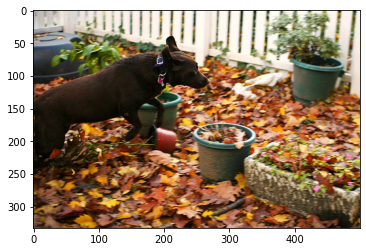

Real:  <start>สุนัขสีน้ำตาลกระโดดขึ้นไปในอากาศเหนือใบไม้หลากสี<end>
Real:  <start>สุนัขกำลังกระโดดขึ้นไปในอากาศเหนือใบไม้บางใบ<end>
Real:  <start>สุนัขกำลังวิ่งผ่านสวนหลังบ้านที่เต็มไปด้วยใบไม้<end>
Real:  <start>สุนัขเคาะกระถางต้นไม้ในสวนที่ปกคลุมไปด้วยใบไม้<end>
Real:  <start>สุนัขสีน้ำตาลตัวเล็ก ๆ อยู่ท่ามกลางกระถางต้นไม้และใบไม้ที่ร่วงหล่น<end>

Baseline:  <start>สุนัขสีดำกระโดดข้ามบาร์เตี้ยๆ ในบริเวณที่มีใบไม้แห้ง<end>
BLEU:  <start>สุนัขสีน้ำตาลตัวใหญ่กระโดดขึ้นไปในอากาศเพื่อจับของเล่นสีเหลือง<end>
################


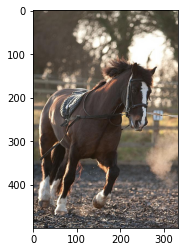

Real:  <start>ม้าสีน้ำตาลและสีขาววิ่งอยู่ในกรวด<end>
Real:  <start>ม้าสีน้ำตาลขาววิ่งเร็ว<end>
Real:  <start>ม้าวิ่ง<end>
Real:  <start>ม้าตัวใหญ่มีเกียร์ แต่ไม่มีคนขี่<end>
Real:  <start>ม้าวิ่งไปรอบสนาม<end>

Baseline:  <start>ม้าสองตัวกำลังเล่นอยู่ในดิน<end>
BLEU:  <start>สุนัขสองตัวกำลังเล่นอยู่ในทราย<end>
################


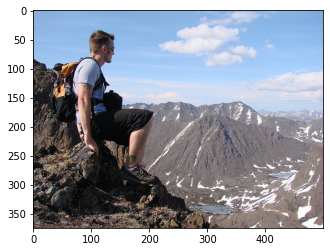

Real:  <start>ผู้ชายกำลังเพลิดเพลินกับวิวจากยอดเขา<end>
Real:  <start>ชายในเสื้อเชิ้ตสีน้ำเงินนั่งบนภูเขาและสะพายเป้<end>
Real:  <start>ชายชุดสีเทาบนหน้าผาหิน มองเห็นภูเขา<end>
Real:  <start>ชายคนหนึ่งนั่งอยู่บนหน้าผาและมองออกไปเห็นภูเขาอีกลูกหนึ่ง<end>
Real:  <start>ชายคนหนึ่งสวมเสื้อเชิ้ตสีเทาและเป้สะพายหลังที่มีภูเขาหิมะเป็นฉากหลัง<end>

Baseline:  <start>ชายคนหนึ่งยืนอยู่บนโขดหินที่มีภูเขาหิมะปกคลุม<end>
BLEU:  <start>ชายคนหนึ่งกำลังกระโดดข้ามกำแพงหินขนาดใหญ่<end>
################


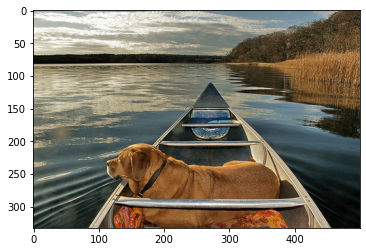

Real:  <start>สุนัขสีน้ำตาลตัวใหญ่ลอยอยู่ในเรือแคนูในแม่น้ำยามพระอาทิตย์ตกดิน<end>
Real:  <start>สุนัขสีน้ำตาลในเรือแคนูมองออกไปเหนือผืนน้ำนิ่ง<end>
Real:  <start>สุนัขกำลังล่องลอยอยู่ในทะเลสาบในเรือลำเล็ก<end>
Real:  <start>หมาอ้วนนั่งเรือ<end>
Real:  <start>สุนัขขนสีทองกำลังนอนอยู่ในเรือที่กำลังเดินทางอยู่ในทะเลสาบ<end>

Baseline:  <start>สุนัขสีน้ำตาลกำลังพายเรือแคนูในทะเลสาบ<end>
BLEU:  <start>สุนัขสีน้ำตาลตัวใหญ่กำลังวิ่งผ่านเรือแคนูในน้ำ<end>
################


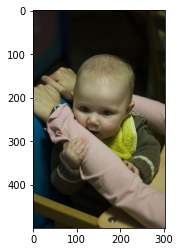

Real:  <start>เด็กทารกดูดแขนสเวตเตอร์ของผู้หญิงที่อุ้มเขา<end>
Real:  <start>ทารกในชุดเอี๊ยมสีเขียวมีแขนโอบรอบตัวเขา<end>
Real:  <start>ทารกในเก้าอี้สูง .<end>
Real:  <start>ทารกนั่งบนเก้าอี้สูงระหว่างแขนของคน<end>
Real:  <start>ทารกกำลังจับแขนของใครบางคน<end>

Baseline:  <start>ทารกนั่งอยู่บนเก้าอี้พลาสติกสีแดง<end>
BLEU:  <start>ทารกที่มีตาสีฟ้านั่งอยู่ในน้ำ<end>
################


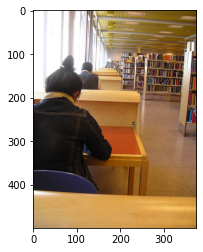

Real:  <start>หญิงสาวที่มีขนมปังนั่งอยู่ที่โต๊ะ<end>
Real:  <start>กลุ่มคนจากด้านหลังนั่งเรียงแถวโต๊ะริมหน้าต่างในห้องสมุด<end>
Real:  <start>ผู้คนกำลังนั่งอยู่ที่โต๊ะทำงานในห้องสมุด<end>
Real:  <start>คนที่นั่งอยู่ที่โต๊ะในห้องสมุด<end>
Real:  <start>คนสองคนนั่งอยู่ที่โต๊ะริมหน้าต่างในห้องสมุด<end>

Baseline:  <start>ชายคนหนึ่งยืนอยู่บนทางเท้า<end>
BLEU:  <start>คนสองคนกำลังดูหิ้งอยู่ในล็อบบี้สเก็ต<end>
################


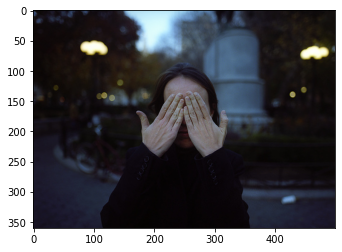

Real:  <start>คนชุดดำเอามือปิดหน้า<end>
Real:  <start>ผู้หญิงปิดตาในสวนสาธารณะเมื่อวันนั้นมาถึง<end>
Real:  <start>ผู้หญิงกำลังปิดตาด้วยมือของเธอ<end>
Real:  <start>คนในแจ็กเก็ตสีดำยืนเอามือปิดตาโดยมีไฟถนนอยู่เบื้องหลัง<end>
Real:  <start>ชายผมสีน้ำตาลสวมเสื้อสเวตเตอร์สีดำเอามือปิดหน้า<end>

Baseline:  <start>ผู้หญิงสวมแว่นยืนอยู่บนถนนที่มีต้นไม้เรียงราย<end>
BLEU:  <start>ชายคนหนึ่งนั่งอยู่บนถนนที่มีหิมะปกคลุม<end>
################


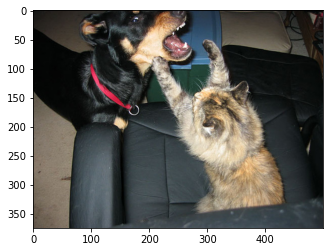

Real:  <start>แมวผ้าดิบยกอุ้งเท้าเข้าหาสุนัขด้วยอ้าปากค้าง<end>
Real:  <start>แมวตบที่สุนัขโดเบอร์แมน<end>
Real:  <start>สุนัขและแมวกำลังต่อสู้กันบนเก้าอี้<end>
Real:  <start>แมวหลากสีสู้กับสุนัขสีดำและสีน้ำตาลในปลอกคอสีแดง<end>
Real:  <start>แมวสีเหลืองและสีดำและสุนัขสีน้ำตาลและสีดำกำลังต่อสู้กัน<end>

Baseline:  <start>สุนัขสีดำกระโดดข้ามขั้นบันได<end>
BLEU:  <start>สุนัขสีดำกระโดดข้ามสุนัขสีน้ำตาลตัวใหญ่<end>
################


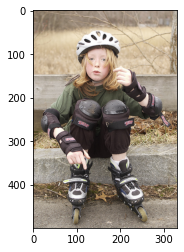

Real:  <start>สาวผมบลอนด์สวมหมวกสีเงิน สนับศอกและเข่า และโรลเลอร์เบลด<end>
Real:  <start>เด็กนั่งบนขอบถนนด้วยอินไลน์สเก็ตและอุปกรณ์ป้องกัน<end>
Real:  <start>เด็กสวมโรลเลอร์เบลดและนั่งบนขอบถนน<end>
Real:  <start>สาวผมบลอนด์สวมหมวกสีเงิน สนับเข่า และโรลเลอร์เบลด<end>
Real:  <start>หญิงสาวหยุดพักจากการเล่นโรลเลอร์เบลด<end>

Baseline:  <start>ชายคนหนึ่งกำลังขี่จักรยานอยู่บนถนนในเมือง<end>
BLEU:  <start>เด็กชายในหมวกกันน็อคกำลังขี่สกู๊ตเตอร์<end>
################


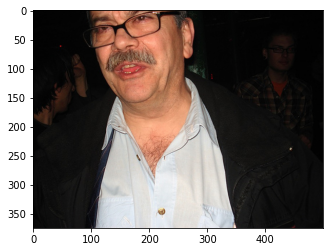

Real:  <start>ภาพระยะใกล้ของชายแก่ใส่แว่นพูด<end>
Real:  <start>ชายคนหนึ่งสวมเสื้อเชิ้ตสีน้ำเงินและแว่นตา .<end>
Real:  <start>ชายสวมแว่นขอบดำและหนวดกำลังพูด<end>
Real:  <start>ผู้ชายใส่แว่นและหนวดอยู่ตรงกลางประโยค<end>
Real:  <start>ชายแก่ใส่แว่นมองกล้อง<end>

Baseline:  <start>ชายในชุดสูทสีดำและหมวกแข็งสีดำกำลังโพสท่าถ่ายรูป<end>
BLEU:  <start>ชายหัวล้านที่มีเครายืนอยู่ข้างชายสวมแว่นที่มีข้อความสีแดง<end>
################


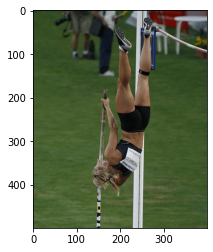

Real:  <start>นักกีฬาทำการกระโดดสูง<end>
Real:  <start>นักกีฬาหญิงกระโดดข้ามบาร์ขณะกระโดดค้ำถ่อ<end>
Real:  <start>ผู้หญิงผิวดำกำลังกระโดดค้ำถ่อ<end>
Real:  <start>ผู้หญิงกระโดดค้ำถ่อคว่ำขณะที่เธอพยายามกระโดดค้ำถ่อ<end>
Real:  <start>ผู้หญิงยกเท้าขึ้นไปในอากาศกำลังจะกระโดดค้ำถ่อ<end>

Baseline:  <start>นักเล่นซอฟต์บอลกำลังแกว่งอยู่บนพื้นหญ้า<end>
BLEU:  <start>นักเล่นซอฟต์บอลกำลังแกว่งอยู่บนพื้นหญ้า<end>
################


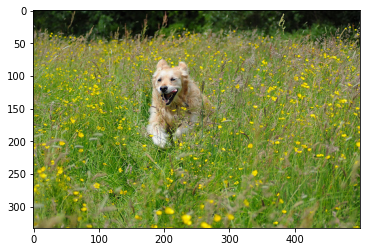

Real:  <start>สุนัขวิ่งผ่านทุ่งดอกไม้สีเหลือง<end>
Real:  <start>สุนัขวิ่งผ่านหญ้ายาว<end>
Real:  <start>โกลเด้นรีทรีฟเวอร์วิ่งผ่านทุ่งดอกไม้สีเหลือง<end>
Real:  <start>สุนัขสีขาววิ่งผ่านทุ่งดอกไม้สีเหลือง<end>
Real:  <start>หมาขาววิ่งผ่านทุ่งดอกไม้สีเหลือง<end>

Baseline:  <start>สุนัขขนปุยวิ่งผ่านหญ้าสูง<end>
BLEU:  <start>สุนัขขนปุยวิ่งผ่านหญ้าสูงมาก<end>
################


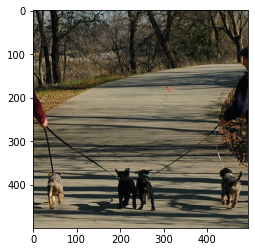

Real:  <start>เจ้าของสองคนกำลังพาสุนัขสี่ตัวไปเดินเล่น<end>
Real:  <start>สุนัขสี่ตัวใส่สายจูงเดินบนทางเท้า<end>
Real:  <start>หมาน้อยสี่ตัวเดินบนทางกว้าง<end>
Real:  <start>สุนัขตัวเล็กสี่ตัวกำลังเดินอยู่ในสวนสาธารณะ<end>
Real:  <start>มีคนกำลังพาสุนัขไปเดินเล่น<end>

Baseline:  <start>สุนัขสองตัวกำลังเล่นอยู่ในสวนสาธารณะ<end>
BLEU:  <start>สุนัขลากเลื่อนบนพื้นไม้<end>
################


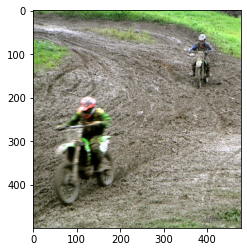

Real:  <start>Dirtbikers แข่งบนเส้นทางที่เต็มไปด้วยโคลน<end>
Real:  <start>นักขี่จักรยาน BMX <UNK>สองคนบนเส้นทางที่เต็มไปด้วยโคลน<end>
Real:  <start>เด็กชายสองคนขี่จักรยานวิบากในโคลน<end>
Real:  <start>ผู้ขับขี่จักรยานสกปรกสองคนขี่จักรยานสกปรก<end>
Real:  <start>คนสองคนขี่จักรยานสกปรกบนเส้นทางจักรยาน<end>

Baseline:  <start>นักขี่จักรยานเสือภูเขากำลังขี่จักรยานอยู่บนเส้นทางลูกรัง<end>
BLEU:  <start>จักรยานยนต์วิบากกำลังขี่จักรยานวิบากตามเส้นทางลูกรัง<end>
################


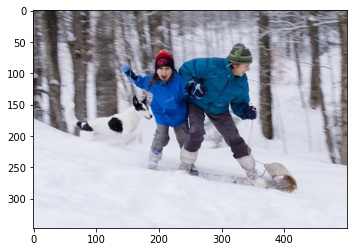

Real:  <start>ผู้หญิงและเด็กผู้หญิงนั่งรถเลื่อนลงเขาโดยยืนขึ้น<end>
Real:  <start>ผู้หญิงและเด็กสาว สวมเสื้อแจ็กเก็ตสีน้ำเงินและหมวกไหมพรม สไลด์ลงเนินบนเลื่อนหิมะ มีสุนัขวิ่งอยู่ข้างๆ<end>
Real:  <start>ผู้หญิงและเด็กสาวกำลังนั่งรถเลื่อนหิมะลงเนินหิมะ<end>
Real:  <start>ผู้หญิงและเด็กผู้หญิงขี่รถเลื่อนไถลลงเนินโดยมีสุนัขวิ่งอยู่ข้างๆ<end>
Real:  <start>คนสองคนบนเลื่อนหิมะลงเขา<end>

Baseline:  <start>นักเล่นสโนว์บอร์ดในหิมะ<end>
BLEU:  <start>นักเล่นสกีกำลังเล่นกลบนหิมะ<end>
################


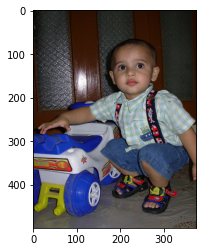

Real:  <start>เด็กชายเล่นกับรถ<end>
Real:  <start>เด็กชายกำลังเล่นกับรถบรรทุก<end>
Real:  <start>ทารกในสายเอี๊ยมนั่งข้างของเล่น<end>
Real:  <start>เด็กชายตัวเล็ก ๆ ที่มีดวงตาสีน้ำตาลโตกำลังจับตัวรถตัวน้อย<end>
Real:  <start>เด็กน้อยใส่กางเกงในเล่นกับรถบรรทุก<end>

Baseline:  <start>เด็กน้อยในชุดสีน้ำเงินกำลังนอนอยู่บนเตียง<end>
BLEU:  <start>เด็กชายตัวเล็ก ๆ กำลังนั่งบนรถของเล่นพลาสติกหลากสี<end>
################


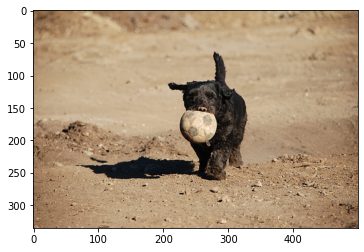

Real:  <start>สุนัขสีดำกัดลูกฟุตบอลบนพื้นดิน<end>
Real:  <start>หมาดำเดินดินมีลูกฟุตบอลอยู่ในปาก<end>
Real:  <start>สุนัขตัวเล็ก ๆ ที่มีลูกฟุตบอลอยู่ในปากกำลังเดินอยู่บนพื้นที่ที่มีสิ่งสกปรกปกคลุม<end>
Real:  <start>หมาดำถือลูกฟุตบอลเก่าเข้าปาก<end>
Real:  <start>สุนัขสีดำกำลังเดินผ่านสิ่งสกปรกพร้อมลูกฟุตบอลอยู่ในปาก<end>

Baseline:  <start>สุนัขสองตัววิ่งอยู่ในทราย<end>
BLEU:  <start>สุนัขสีดำวิ่งไปตามทางดิน<end>
################


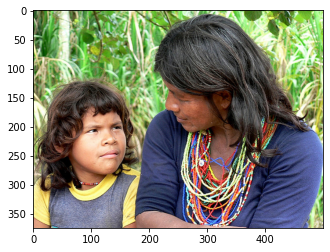

Real:  <start>เด็กและผู้ใหญ่มองหน้ากัน<end>
Real:  <start>ชายและหญิงนั่งลง<end>
Real:  <start>ผู้หญิงที่สวมสร้อยคอลูกปัดจำนวนมากมองดูเด็กที่มีเพียงคนเดียว<end>
Real:  <start>ผู้หญิงที่สวมสร้อยคอลูกปัดมองลงไปที่หญิงสาวที่นั่งอยู่ข้างๆ เธอ<end>
Real:  <start>ผู้หญิงชนเผ่าและเด็กจ้องมองกันอยู่ในป่า<end>

Baseline:  <start>เด็กผู้หญิงกำลังเป่าฟองสบู่ที่มีผมยาว<end>
BLEU:  <start>เด็กสาวสองคนนั่งบนม้านั่ง<end>
################


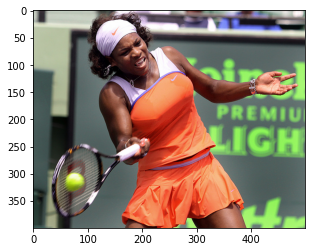

Real:  <start>หญิงชาวแอฟริกันอเมริกันในชุดสีส้มกำลังตีลูกเทนนิสด้วยไม้เทนนิส<end>
Real:  <start>นักเทนนิสในชุดสีส้มตีลูกบอล<end>
Real:  <start>นักเทนนิสในชุดสีส้มกำลังตีลูกบอลด้วยไม้เทนนิสของเธอ<end>
Real:  <start>ผู้หญิงในชุดกีฬาสีส้มกำลังเล่นเทนนิส<end>
Real:  <start>เซเรน่า วิลเลียมส์ตีลูกบอลในชุดสีส้ม<end>

Baseline:  <start>นักเทนนิสที่มีไม้เทนนิสอยู่ในปาก<end>
BLEU:  <start>ผู้หญิงกำลังตีลูกพร้อมตีลูก<end>
################


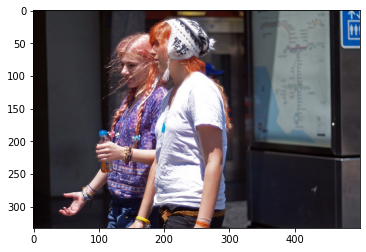

Real:  <start>เด็กผู้หญิงผมสีส้มยืนถือขวดเหล้าอยู่บนถนน<end>
Real:  <start>สองสาวเดินถนน<end>
Real:  <start>สองสาวเดินเคียงข้างกันและพูดคุยกัน<end>
Real:  <start>เด็กสาววัยรุ่นสองคนแต่งตัวเหมือนฮิปปี้เดินคุยกัน<end>
Real:  <start>ผู้หญิงสองคน คนหนึ่งมีผ้าโพกหัว ยืนข้างกันในขณะที่อีกคนถือขวด<end>

Baseline:  <start>ผู้หญิงในชุดขาวยืนอยู่บนถนนในเมือง<end>
BLEU:  <start>ชายสองคนกำลังเล่นอยู่ในสนาม<end>
################


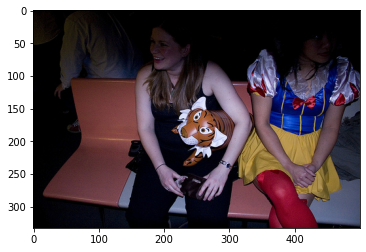

Real:  <start>เด็กผู้หญิงถือเสือระเบิดในขณะที่ผู้หญิงอีกคนอยู่ในชุด<end>
Real:  <start>เด็กผู้หญิงนั่งบนม้านั่งถือเสือพองตัวข้างหญิงสาวอีกคนในชุดสีสันสดใส<end>
Real:  <start>สาวๆนั่งแต่งตัว.<end>
Real:  <start>เด็กหญิงชุดดำถือของเล่นและนั่งถัดจากหญิงสาวในชุดแต่งกาย<end>
Real:  <start>ผู้หญิงสองคนนั่งอยู่บนม้านั่ง ปิดบังใบหน้า โดยผู้หญิงคนหนึ่งถือเสือพองตัว และผู้หญิงอีกคนในชุดเครื่องแต่งกายสีขาวเหมือนหิมะของดิสนีย์<end>

Baseline:  <start>เด็กสองคนกำลังเล่นอยู่ในสระ<end>
BLEU:  <start>เด็กหญิงตัวเล็ก ๆ กำลังเล่นอยู่ในสระ<end>
################


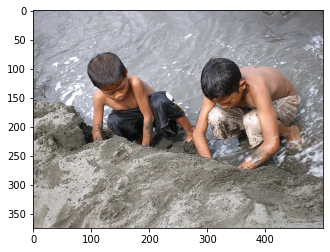

Real:  <start>เด็กๆ อยู่ใกล้กับกองทรายขนาดใหญ่ที่อยู่ติดกับน้ำ<end>
Real:  <start>เด็กชายทั้งสองกำลังเล่นอยู่ในทรายเปียก<end>
Real:  <start>เด็กชายสองคนเล่นทราย<end>
Real:  <start>เด็กหนุ่มร่างผอมสองคนกำลังเล่นทรายในน้ำ<end>
Real:  <start>เด็กสองคนนั่งอยู่ในน้ำและขุดทราย<end>

Baseline:  <start>ชายคนหนึ่งยืนอยู่บนโขดหินบนชายหาด<end>
BLEU:  <start>เด็กชายสามคนกำลังปีนขึ้นไปบนกำแพงหิน<end>
################


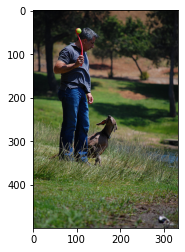

Real:  <start>ผู้ชายกำลังจะขว้างลูกเทนนิสให้สุนัขสีน้ำตาลบนพื้นหญ้า<end>
Real:  <start>ชายคนหนึ่งเตรียมโยนลูกบอลให้สุนัข<end>
Real:  <start>ชายคนหนึ่งเตรียมขว้างลูกเทนนิสให้สุนัขของเขา<end>
Real:  <start>ชายคนหนึ่งมีลูกบอลสีเหลืองบนแท่งสีแดง<end>
Real:  <start>ชายคนนั้นกำลังขว้างลูกเทนนิสให้สุนัขสีน้ำตาลหยิบขึ้นมา<end>

Baseline:  <start>เด็กชายตัวเล็ก ๆ กำลังเล่นอยู่ในหญ้า<end>
BLEU:  <start>ชายคนหนึ่งกำลังเล่นว่าวอยู่ในทุ่งหญ้าเขียวขจี<end>
################


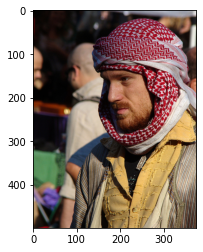

Real:  <start>ผู้ชายสวมผ้าพันคอสีแดง<end>
Real:  <start>คนที่มีผ้าคลุมศีรษะ<end>
Real:  <start>ชายคนหนึ่งสวมผ้าพันคออาหรับ โดยมีชายอีกคนหนึ่งอยู่เบื้องหลัง<end>
Real:  <start>ชายผิวขาวในผ้าโพกหัว .<end>
Real:  <start>ชายผู้มีผมหน้าแดงสวมผ้าคลุมศีรษะสไตล์ปาเลสไตน์สีแดงและสีขาว<end>

Baseline:  <start>ชายคนหนึ่งถือกล้อง<end>
BLEU:  <start>ชายคนหนึ่งสวมหมวกสีดำและหมวกที่มีผู้คนมากมาย<end>
################


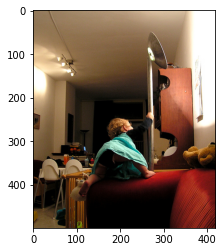

Real:  <start>ทารกยืนอยู่ข้างโซฟาและเคาะโคมไฟ<end>
Real:  <start>เด็กน้อยปีนขึ้นไปบนแขนของโซฟาสีแดง<end>
Real:  <start>เด็กในบ้าน ปีนขึ้นไปบนแขนโซฟาสีแดง เอื้อมมือไปหยิบโคมไฟ<end>
Real:  <start>เด็กหญิงตัวเล็ก ๆ ในชุดสีฟ้าครามบนแขนของเก้าอี้เอื้อมมือไปหยิบโคมไฟตั้งพื้น<end>
Real:  <start>ผู้หญิงนั่งอยู่บนโซฟาสีแดงภายในบ้าน<end>

Baseline:  <start>ชายคนหนึ่งนั่งอยู่บนม้านั่งในห้อง<end>
BLEU:  <start>ชายคนหนึ่งนั่งบนพื้น<end>
################


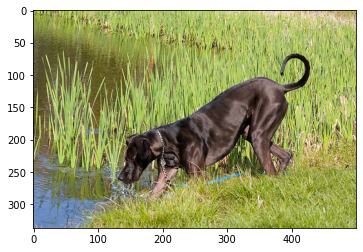

Real:  <start>สุนัขสีน้ำตาลกำลังลุยลงไปในแอ่งน้ำ<end>
Real:  <start>สุนัขตัวหนึ่งอยู่บนขอบของน้ำ<end>
Real:  <start>สุนัขกำลังเดินลงไปในทะเลสาบที่มีต้นกกอยู่ด้านหลัง<end>
Real:  <start>สุนัขสวมสายจูงสีน้ำเงินเดินเข้าไปในแหล่งน้ำ<end>
Real:  <start>สุนัขสีน้ำตาลตัวใหญ่เอนกายลงไปในน้ำจากริมหญ้า<end>

Baseline:  <start>สุนัขสีดำสองตัววิ่งผ่านหญ้าสูง<end>
BLEU:  <start>สุนัขสีดำและสุนัขสีน้ำตาลตัวหนึ่งวิ่งผ่านหญ้า<end>
################


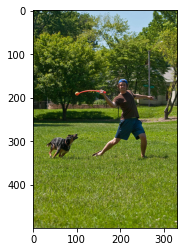

Real:  <start>ผู้ชายกำลังจะขว้างของเล่นให้สุนัขไปหยิบ<end>
Real:  <start>ชายคนหนึ่งขว้างลูกบอลให้สุนัข<end>
Real:  <start>ชายคนหนึ่งขว้างไม้สีแดงให้สุนัขดึง<end>
Real:  <start>คนขว้างของเล่นสีแดงให้สุนัขวิ่งไปหา<end>
Real:  <start>ชายคนนั้นกำลังขว้างของเล่นให้สุนัขสีน้ำตาลและสีดำในสวนสาธารณะ<end>

Baseline:  <start>เด็กสองคนกำลังเล่นฟุตบอลอยู่ในสนาม<end>
BLEU:  <start>เด็กชายตัวเล็ก ๆ กำลังกระโดดขึ้นไปในอากาศเพื่อจับลูกบอลในสวนสาธารณะ<end>
################


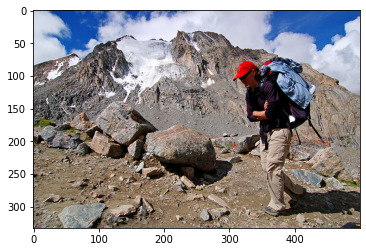

Real:  <start>แบ็คแพ็คเกอร์กำลังเดินอยู่หน้าภูเขาพร้อมกับกอดอก<end>
Real:  <start>นักปีนเขาสวมหมวกสีแดงเดินไปตามเส้นทางบนภูเขา<end>
Real:  <start>นักปีนเขาพร้อมเป้สะพายหลังกำลังเดินโดยมีภูเขาที่ปกคลุมไปด้วยหิมะอยู่ด้านหลัง<end>
Real:  <start>คนในหมวกแดงแบกเป้ใบใหญ่ไปเดินป่า<end>
Real:  <start>ผู้หญิงคนหนึ่งถือตัวเองขณะที่เธอเดินป่าในภูมิประเทศที่เป็นภูเขา<end>

Baseline:  <start>ชายคนหนึ่งกำลังเดินป่าอยู่บนหิน<end>
BLEU:  <start>ชายคนหนึ่งยืนอยู่บนกองหิมะ<end>
################


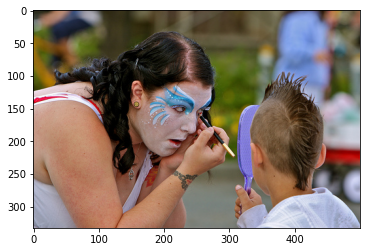

Real:  <start>ผู้หญิงใช้สีทาหน้าในขณะที่เด็กชายถืออินเดียนแดงถือกระจก<end>
Real:  <start>ผู้หญิงวาดภาพใบหน้าของเธอในขณะที่เด็กที่มีอินเดียนแดงถือกระจก<end>
Real:  <start>ผู้หญิงกำลังแต่งหน้า<end>
Real:  <start>ผู้หญิงคนหนึ่งวาดภาพใบหน้าของเธอในขณะที่เด็กผู้ชายที่มีอินเดียนแดงถือกระจกของเธอ<end>
Real:  <start>เด็กตัดผมทรงอินเดียนแดงถือกระจกสำหรับผู้หญิงทาหน้า<end>

Baseline:  <start>ผู้หญิงกำลังเป่าฟองสบู่อยู่ในน้ำ<end>
BLEU:  <start>ผู้หญิงถือกล้องและยิ้ม<end>
################


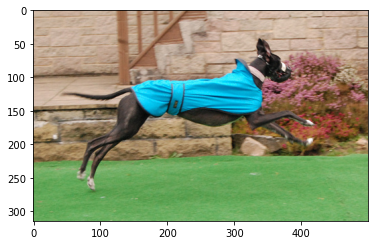

Real:  <start>หมาดำสวมเสื้อสีน้ำเงินกระโดดขึ้นไปในอากาศ<end>
Real:  <start>สุนัขสวมเสื้อสีน้ำเงินกำลังวิ่งและกระโดดขึ้นไปในอากาศ<end>
Real:  <start>สุนัขที่มีผ้าห่มสีน้ำเงินวิ่งผ่านหญ้า<end>
Real:  <start>สุนัขที่มีปากกระบอกปืนและแจ็กเก็ตสีน้ำเงินวิ่งไปรอบๆ สนาม<end>
Real:  <start>สุนัขเกรย์ฮาวด์สีดำกำลังวิ่งอยู่บนพื้นหญ้าโดยสวมแจ็กเก็ตสีน้ำเงิน<end>

Baseline:  <start>สุนัขสีดำกำลังกระโดดข้ามสิ่งกีดขวาง<end>
BLEU:  <start>สุนัขสีดำกระโดดไปหาลูกบอลสีเหลือง<end>
################


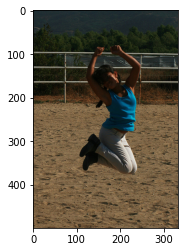

Real:  <start>หญิงสาวในเสื้อเชิ้ตสีน้ำเงินกระโดดขึ้นไปในอากาศ<end>
Real:  <start>หญิงสาวในกางเกงสีขาวและเสื้อกล้ามสีน้ำเงินกระโดด<end>
Real:  <start>นักขี่ม้ากระโดดขึ้นไปในอากาศในลานม้า<end>
Real:  <start>หญิงสาวคนหนึ่งถ่ายภาพขณะกระโดดร่ม ในพื้นที่รั้วรอบขอบชิด<end>
Real:  <start>หญิงสาวสวมเสื้อสีน้ำเงินและกระโดดขึ้นไปในอากาศ<end>

Baseline:  <start>เด็กชายกำลังเล่นอยู่ในสนาม<end>
BLEU:  <start>เด็กชายตัวเล็ก ๆ กระโดดลงไปในทราย<end>
################


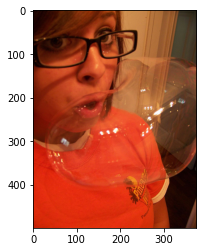

Real:  <start>เด็กผู้หญิงกำลังเป่าฟองสบู่ขนาดใหญ่<end>
Real:  <start>เด็กสาวสวมแว่นและเสื้อยืดสีส้มเป่าฟองสบู่ใสขนาดใหญ่<end>
Real:  <start>สาวเสื้อแดงเป่าฟองสบู่<end>
Real:  <start>หญิงสาวสวมเสื้อสีส้มและแว่นตากำลังเป่าฟองสบู่ขนาดใหญ่<end>
Real:  <start>เด็กสาวเป่าฟองสบู่ขนาดใหญ่<end>

Baseline:  <start>ชายคนหนึ่งสวมผ้ากันเปื้อนและหมวกกันน๊อค<end>
BLEU:  <start>ชายคนหนึ่งกำลังเล่นอยู่ในหลุมที่มีลูกโป่งสีเขียว<end>
################


In [140]:
with torch.no_grad():
  transformed_img, captions, caption_n_gram_count, img, all_captions = next(iter(test_flickr_bleu_dataloader))
  transformed_img, captions = transformed_img.to(device), captions.to(device)

  bleu_text_output, _ = baseline_model.generate_text(transformed_img)
  baseline_text_output, _ = bleu_model.generate_text(transformed_img)

  for i in range(len(transformed_img)):
    plt.imshow(img[i])
    plt.show()
    for caption in all_captions[i]:
      caption = [dictionary.itos[token.item()] for token in caption]
      reference.append(caption)
      print("Real: ", "".join(caption))
    print()
    print("Baseline: ", "".join(baseline_text_output[i]) )
    print("BLEU: ", "".join(bleu_text_output[i]) )
    print("################")